In [1]:
import os
import sys

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
from hydra import initialize, compose
import pickle
from glob import glob
from pyHalo.preset_models import CDM
from tqdm import tqdm

# set paths to various directories based on the machine this code is being executed on
with initialize(version_base=None, config_path='config'):
    config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.lenses.test import SampleStrongLens
from mejiro.plots import diagnostic_plot, plot, plot_util, overplot
from mejiro.analysis import stats
from mejiro.utils import util
from mejiro.helpers import pyhalo, pandeia_input

In [2]:
# open pickled lens list
pickled_lens_list = os.path.join(config.machine.dir_01, '01_hlwas_sim_detectable_lens_list.pkl')
lens_list = util.unpickle(pickled_lens_list)
assert len(lens_list) != 0, f'No pickled lenses found. Check {pickled_lens_list}.'
count = len(lens_list)

In [3]:
success = 0
fail = 0
success_list = []
fail_list = []

for i in tqdm(range(400)):
    lens = np.random.choice(lens_list)

    pipeline_params = util.hydra_to_dict(config.pipeline)
    subhalo_cone = pipeline_params['subhalo_cone']
    los_normalization = pipeline_params['los_normalization']

    # circumvent bug with pyhalo, sometimes fails when redshifts have more than 2 decimal places
    z_lens = round(lens.z_lens, 2)
    z_source = round(lens.z_source, 2)

    log_m_host = np.log10(lens.main_halo_mass)
    r_tidal = 0.5  # see Section 3.1 of Gilman et al. 2020 https://ui.adsabs.harvard.edu/abs/2020MNRAS.491.6077G/abstract 
    sigma_sub = 0.055  # see Section 6.3 of Gilman et al. 2020 https://ui.adsabs.harvard.edu/abs/2020MNRAS.491.6077G/abstract 

    try:
        cdm_realization = CDM(z_lens,
                    z_source,
                    sigma_sub=sigma_sub,
                    log_mlow=6.,
                    log_mhigh=10.,
                    log_m_host=log_m_host,
                    r_tidal=r_tidal,
                    cone_opening_angle_arcsec=subhalo_cone,
                    LOS_normalization=los_normalization)
        success += 1
        success_list.append(lens)
    except:
        fail += 1
        fail_list.append(lens)

100%|██████████| 400/400 [06:30<00:00,  1.03it/s]


In [4]:
print(f'Success: {success}, Fail: {fail}, Success rate: {success/(success+fail)}')

Success: 400, Fail: 0, Success rate: 1.0


In [5]:
# for lens in success_list:
#     print(lens.main_halo_mass)

In [6]:
# for lens in fail_list:
#     print(lens.main_halo_mass)

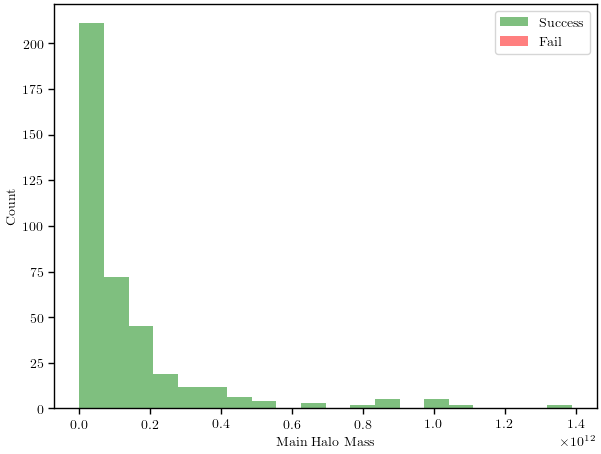

In [7]:
plt.hist([lens.main_halo_mass for lens in success_list], bins=20, alpha=0.5, label='Success', color='g')
plt.hist([lens.main_halo_mass for lens in fail_list], bins=20, alpha=0.5, label='Fail', color='r')
plt.xlabel('Main Halo Mass')
plt.ylabel('Count')
plt.legend()
plt.show()

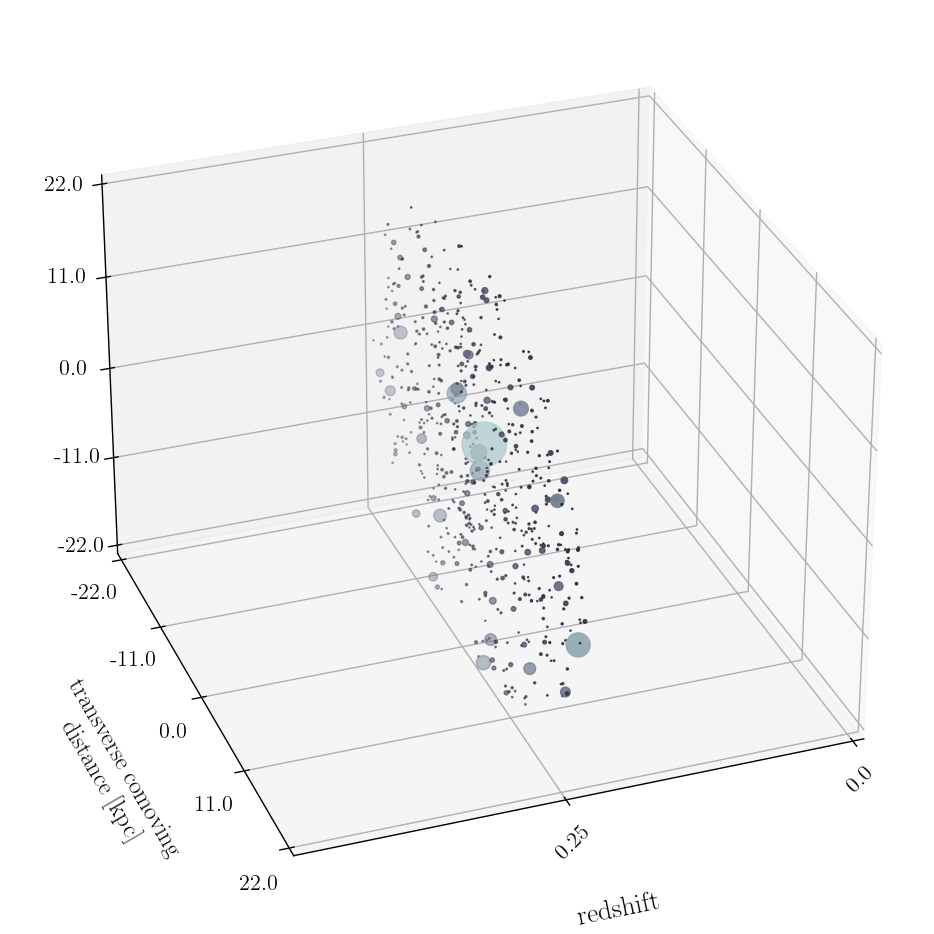

In [9]:
fig = plt.figure(2)
fig.set_size_inches(14,12)
ax = plt.subplot(111, projection='3d')
cdm_realization.plot(ax)